In [149]:
# importing data manipulation as well as plotting packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# importing statistical packages
import statsmodels.api as sm
import scipy
from statsmodels.formula.api import ols

%matplotlib inline

# Loading Datasets

In [719]:
def data_load(filename):
    '''Loads data in CSV format, produces pandas dataframe for data, 
    and converts index to datetime, only input required is 
     the file paths'''
    ''' input must have date column labeled 'DATE', and the file path 
    must be in quotes'''
    
    assert type(filename) == str, 'filename_1 should be a string'

    # loading the first dataset and changing the index column to the date
    dataset = pd.read_csv(filename, sep=',', index_col='DATE')
    # converting the date index to datetime
    dataset.index = pd.to_datetime(dataset.index)
    
    return dataset
    

In [720]:
# loading both the environment Canada data and the zooplankton data
gwv_data = data_load('../data/c46131.csv')
zoo = data_load('../data/Zooplankton_2009-2012.csv')

# Sentry Shoals Environment Canada Data

# Discovery Passage Zooplankton Abundance
                                                     

The primary goal of this project is to compare Discovery passage zooplankton abundance with nearby Sentry Shoals sea surface temperature and significant wave height (proxy for vertical turnover). In order to do this I want to create a timeseries plot comparing the zooplankton abundance for a certain year to the significant wave height and the sea surface temperature. This plot will allow me to visually observe the trends of these three varaibles over the course of the spring bloom season. Then I will statistically compare these three varaibles using a few different tests. 

The largest problem with producing a timeseries plot from these datasets (Discovery Passage zooplankton and Sentry Shoals Environment Canada) is the mismatch in their observation frequencies. Therefore I made a function that would automatically munge the data and put it into a new dataframe for for further work such as plotting or statistical analysis. The function requires 4 inputs, the year desired, and the 3 column names of the varaibles of interest. The funcion first resamples the columns on a weekly average to ensure unity in the timescale used for the date. Then the data is selected for only the spring bloom season. This time period is year specific and is determined by the timeline of plankton samples that year. Finally the data is inputted into the new datatable, where it can be used for further plotting or statistical analysis. Unfornately this function is limited to taking 2 columns from the first dataset, and only 1 from the second dataset. Thus, the column_1 and column_2 inputs are strictly for the first dataset's columns and the column_3 input is for the second dataset's columns. I hope to improve this model in the coming days by making it into a script  which can load the data as well.

Below, I use the function to make 4 datatables of the spring bloom season for the years of 2009-2012. Each datatable is composed of significant wave height, sea surface temperature and zooplankton abundance over this time. 

In [722]:
def spring_wk(year, dataset_1, dataset_2, column_1, column_2, column_3):
    '''For either of my two datasets, this function will average any 3 variables
     on a weekly basis for any spring between 2009-2012. The outputs of this munged data 
     is inserted into a new dataframe'''
    
    assert 2009 <= year <= 2012, 'Year should be between 2009 and 2012'
    assert len(column_1) > 1
    assert len(column_2) > 1
    assert len(column_3) > 1
    assert dataset_1.index.name == 'DATE', 'index should be in terms of date and named DATE'
    assert dataset_2.index.name == 'DATE', 'index should be in terms of date and named DATE'
    
    # Ensuring dataset_1 index (time) is in pandas datetime format
    #dataset_1.index = pd.to_datetime(dataset_1.index, unit='m')

    # Resampling the columns from dataset_1 into weekly averages
    column_1_weekly = column_1.resample('W', how=('mean'))
    column_2_weekly = column_2.resample('W', how=('mean'))
    
    # Subsetting the columns from dataset_1 for the spring plankton bloom in the specified year
    if year == 2009:
        first ='2009-02-24'
        last = '2009-07-05' 
    if year == 2010:
        first = '2010-03-03'
        last = '2010-6-28'   
    if year == 2011:
        first = '2011-03-07'
        last = '2011-07-03'
    if year == 2012:
        first ='2012-03-30'
        last = '2012-07-01'
    column_1_weekly_year = column_1_weekly[first:last]
    column_2_weekly_year = column_2_weekly[first:last]
    
    

    # dropping the rows where naN's are present in dataset_1
    column_1_weekly_year_new = column_1_weekly_year.dropna()
    column_2_weekly_year_new = column_2_weekly_year.dropna()
    
    # Ensuring dataset_2 index (time) in in pandas datetime format
    #dataset_2.index = pd.to_datetime(dataset_2.index, unit='d')
    
    # Now resampling column from dataset_2 into weekly averages over the desired spring
    if year == 2009:
        yr = '2009'
    if year == 2010:
        yr = '2010'
    if year == 2011:
        yr = '2011'
    if year == 2012:
        yr = '2012'
    column_3_year = column_3[yr]
    column_3_year_weekly = column_3_year.resample('W', how=('mean'))
    
    # Combines the three columns across the two datasets into a single dataframe
    combination_data = pd.DataFrame({column_1.name : column_1_weekly_year_new, column_2.name : column_2_weekly_year_new, column_3.name : column_3_year_weekly})
    combination_data = combination_data.dropna()
    
    return combination_data

In [723]:
comb_2012 = spring_wk(2012, gwv_data, zoo, gwv_data.sig_wave_height, gwv_data.sea_surface_temperature, zoo.Total_Zooplankton_Abundance)
comb_2011 = spring_wk(2011, gwv_data, zoo, gwv_data.sig_wave_height, gwv_data.sea_surface_temperature, zoo.Total_Zooplankton_Abundance)
comb_2010 = spring_wk(2010, gwv_data, zoo, gwv_data.sig_wave_height, gwv_data.sea_surface_temperature, zoo.Total_Zooplankton_Abundance)
comb_2009 = spring_wk(2009, gwv_data, zoo, gwv_data.sig_wave_height, gwv_data.sea_surface_temperature, zoo.Total_Zooplankton_Abundance)

To show the progression and interaction of sea surface temperature, significant wave height, and zooplankton abundance, I use the 4 datatables above to graph a timeseries plot for each spring between 2009-2012 for the three variables. In order to make the code for these plots efficient and streamlined, I made a function that would plot a timeseries for any three general variables. The function requires 5 inputs; the dataset name, the three column names for the varaibles of interest, and the savename that the plot will be saved to. This function assumes that all data plotted is from one dataset. Additionally, the savename must be in quotations, and the varaible's must be in the format of dataset.column_name in order for the function to recognize them. 

In [737]:
def timeseries(dataset, variable_1, variable_2, variable_3, savename):
    '''Function plots any three varaibles into timeseries plot and saves plot. 
    Only required inputs are dataset name, 3 variables of interest in the format:
    dataset.column_name and the savename in quotations'''
    
    assert type(savename) == str, 'the output file name (savename) must be a string'
    assert len(dataset) > 1, 'dataset should have a length of more than 1 in order to plot'
    
    fig = plt.figure(figsize=(12, 5)) 
    
    # layering the three axes, which contain the three varaibles, on top of one another to create a single subplot
    # layering completed with twinx() method
    ax1 = plt.subplot()
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    # plotting the 3 variables into the predetermined plot outlined above
    # Setting the color and width of lines on the graph
    ax1.plot(dataset.index, variable_1, 'k-', linewidth =2)
    ax2.plot(dataset.index, variable_2, 'grey', linewidth=2)
    ax3.plot(dataset.index, variable_3, 'g-', linewidth=4)
    
    # moving the spine that the zooplankton was plotted onto towards the right so it isnt on top of the second spine(ax2)
    variable_3_spine = ax3.spines['right']
    variable_3_spine.set_position(('axes', 1.1))

    # Adjusting the color of the axes ticks to match line color
    ax1.yaxis.set_tick_params(labelcolor='k')
    ax2.yaxis.set_tick_params(labelcolor='grey')
    ax3.yaxis.set_tick_params(labelcolor='green')
    
    # Making axes labels, selecting their color, and selecting their size
    ax1.set_xlabel(dataset.index.name, fontsize=14, y=0)
    ax1.set_ylabel(variable_1.name, fontsize = 13, color ='k')
    ax2.set_ylabel(variable_2.name + '($^o$C)', fontsize = 13, color='grey')
    ax3.set_ylabel(variable_3.name + '(m$^3$)', fontsize = 13, color='g')
    
    plt.savefig('../results/computational_experiments/'+savename+'.pdf')

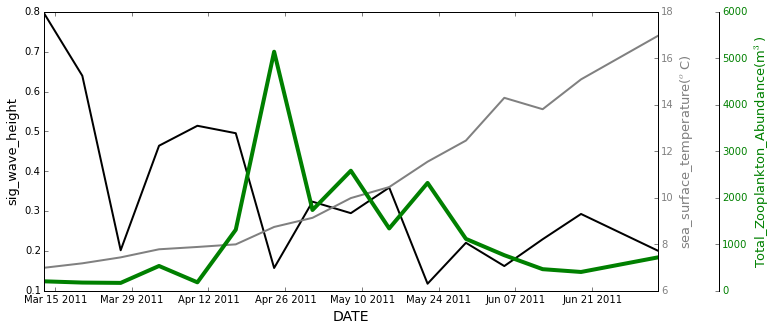

In [736]:
# testing this function for the year 2012
timeseries(comb_2011, comb_2011.sig_wave_height, comb_2011.sea_surface_temperature, comb_2011.Total_Zooplankton_Abundance, 't_series_2011')

Unfortunatly I was not able to join of each of these plots together in the same panel. However I still wanted to do this for the final report, so I had to do it manually (without the function above). I would love some feedback on this. The code below is extremely long, very repetitive and I know their must be a better way that I just havent found.

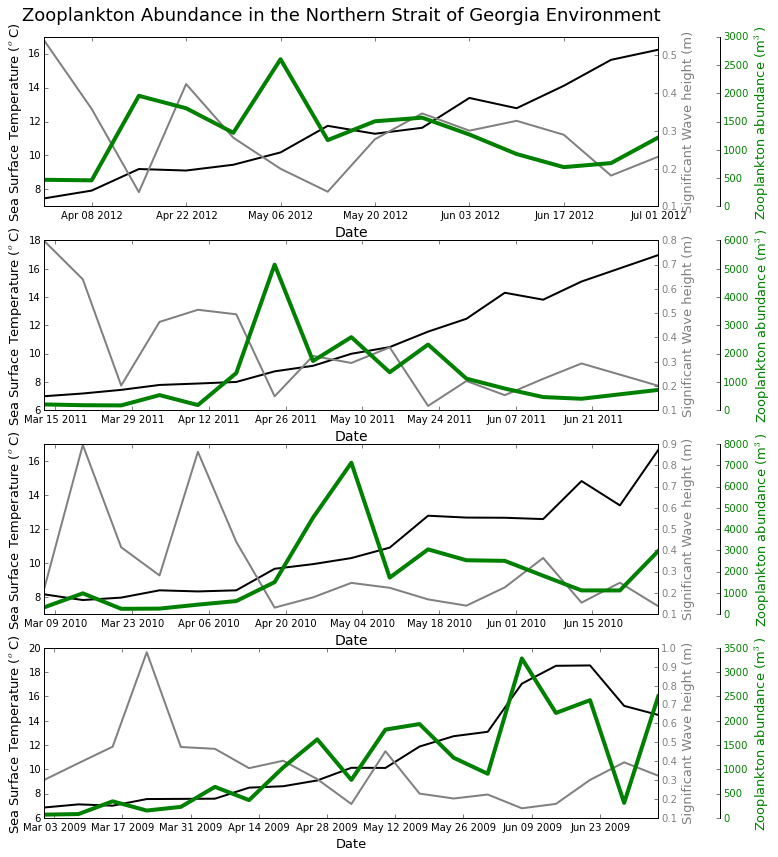

In [753]:
# Creating 4 timeseries subplots for the weekly averages of zooplankton abundance, sea surface temperature, and significant wave height during the springs of 2009-2012

# Adjusting the figure size
fig = plt.figure(figsize=(11, 14)) 

#Creating a super title for all of my subplots
plt.suptitle('Zooplankton Abundance in the Northern Strait of Georgia Environment', fontsize=18, y=0.93)

# CREATING THE FIRST SUBPLOT

# layering the three axes, which contain the three varaibles, on top of one another to create a single subplot
# layering completed with twinx() method
ax1 = plt.subplot(4,1,1)
ax2 = ax1.twinx()
ax3 = ax1.twinx()

# plotting the 3 variables into the predetermined plot outlined above
# Setting the color and width of lines on the graph
ax1.plot(comb_2012.index, comb_2012.sea_surface_temperature, 'k-', linewidth =2)
ax2.plot(comb_2012.index, comb_2012.sig_wave_height, 'grey', linewidth=2)
ax3.plot(comb_2012.index, comb_2012.Total_Zooplankton_Abundance, 'g-', linewidth=4)
    
# moving the spine that the zooplankton was plotted onto towards the right so it isnt on top of the second spine(ax2)
column_3_spine = ax3.spines['right']
column_3_spine.set_position(('axes', 1.1))

# Adjusting the color of the axes ticks to match line color
ax1.yaxis.set_tick_params(labelcolor='k')
ax2.yaxis.set_tick_params(labelcolor='grey')
ax3.yaxis.set_tick_params(labelcolor='green')

# Making axes labels, selecting their color, and selecting their size
ax1.set_xlabel('Date', fontsize=14, y=0)
ax1.set_ylabel('Sea Surface Temperature ($^o$C)', fontsize = 13, color ='k')
ax2.set_ylabel('Significant Wave height (m)', fontsize = 13, color='grey')
ax3.set_ylabel('Zooplankton abundance (m$^3$)', fontsize = 13, color='g')

# CREATING THE SECOND SUBPLOT

# layering the three axes, which contain the three varaibles, on top of one another to create a single subplot
# layering completed with twinx() method
ax4 = plt.subplot(4,1,2)
ax5 = ax4.twinx()
ax6 = ax4.twinx()

# plotting the 3 variables into the predetermined plot outlined above
# Setting the color and width of lines on the graph
ax4.plot(comb_2011.index, comb_2011.sea_surface_temperature, 'k-', linewidth =2)
ax5.plot(comb_2011.index, comb_2011.sig_wave_height, 'grey', linewidth=2)
ax6.plot(comb_2011.index, comb_2011.Total_Zooplankton_Abundance, 'g-', linewidth=4)

# moving the spine that the zooplankton was plotted onto towards the right so it isnt on top of the second spine(ax2)
column_6_spine = ax6.spines['right']
column_6_spine.set_position(('axes', 1.1))

# Adjusting the color of the axes ticks to match line color
ax4.yaxis.set_tick_params(labelcolor='k')
ax5.yaxis.set_tick_params(labelcolor='grey')
ax6.yaxis.set_tick_params(labelcolor='green')

# Making axes labels, selecting their color, and selecting their size
ax4.set_xlabel('Date', fontsize=14, y=0)
ax4.set_ylabel('Sea Surface Temperature ($^o$C)', fontsize = 13, color ='k')
ax5.set_ylabel('Significant Wave height (m)', fontsize = 13, color='grey')
ax6.set_ylabel('Zooplankton abundance (m$^3$)', fontsize = 13, color='g')

# CREATING THE THIRD SUBPLOT

# layering the three axes, which contain the three varaibles, on top of one another to create a single subplot
# layering completed with twinx() method
ax7 = plt.subplot(4,1,3)
ax8 = ax7.twinx()
ax9 = ax7.twinx()

# plotting the 3 variables into the predetermined plot outlined above
# Setting the color and width of lines on the graph
ax7.plot(comb_2010.index, comb_2010.sea_surface_temperature, 'k-', linewidth =2)
ax8.plot(comb_2010.index, comb_2010.sig_wave_height, 'grey', linewidth=2)
ax9.plot(comb_2010.index, comb_2010.Total_Zooplankton_Abundance, 'g-', linewidth=4)

# moving the spine that the zooplankton was plotted onto towards the right so it isnt on top of the second spine(ax2)
column_9_spine = ax9.spines['right']
column_9_spine.set_position(('axes', 1.1))

# Adjusting the color of the axes ticks to match line color
ax7.yaxis.set_tick_params(labelcolor='k')
ax8.yaxis.set_tick_params(labelcolor='grey')
ax9.yaxis.set_tick_params(labelcolor='green')

# Making axes labels, selecting their color, and selecting their size
ax7.set_xlabel('Date', fontsize=14, y=0)
ax7.set_ylabel('Sea Surface Temperature ($^o$C)', fontsize = 13, color ='k')
ax8.set_ylabel('Significant Wave height (m)', fontsize = 13, color='grey')
ax9.set_ylabel('Zooplankton abundance (m$^3$)', fontsize = 13, color='g')

# CREATING THE FOURTH SUBPLOT

# layering the three axes, which contain the three varaibles, on top of one another to create a single subplot
# layering completed with twinx() method
ax10= plt.subplot(4,1,4)
ax11 = ax10.twinx()
ax12 = ax10.twinx()

# Setting the color and width of lines on the graph
ax10.plot(comb_2009.index, comb_2009.sea_surface_temperature, 'k-', linewidth =2)
ax11.plot(comb_2009.index, comb_2009.sig_wave_height, 'grey', linewidth=2)
ax12.plot(comb_2009.index, comb_2009.Total_Zooplankton_Abundance, 'g-', linewidth=4)

# moving the spine that the zooplankton was plotted onto towards the right so it isnt on top of the second spine(ax2)
column_12_spine = ax12.spines['right']
column_12_spine.set_position(('axes', 1.1))

# Adjusting the color of the axes ticks to match line color
ax10.yaxis.set_tick_params(labelcolor='k')
ax11.yaxis.set_tick_params(labelcolor='grey')
ax12.yaxis.set_tick_params(labelcolor='green')


# Making axes labels, selecting their color, and selecting their size
ax10.set_xlabel('Date', fontsize=13, y=0)
ax10.set_ylabel('Sea Surface Temperature ($^o$C)', fontsize = 13, color ='k')
ax11.set_ylabel('Significant Wave height (m)', fontsize = 13, color='grey')
ax12.set_ylabel('Zooplankton abundance (m$^3$)', fontsize = 13, color='g')

# Saving the plot and ensuring the second y-axis fits within the pdf
plt.savefig('../../../Documents/total_timeseries.pdf', bbox_inches='tight')

# Showing the plot
plt.show()
    

# Statistics

While my project centers on the affects of environmental conditions on plankton abundance it is important to understand the interaction between these evironmental conditions since it is this interaction and not one condition alone that dictates plankton abundance. Therefore I will give a breif statistical analysis of the relationship between sea surface temperature and significant wave height. I begin by using my data munging function to subset that data for the years of 2009-2012 (Zooplankton collection years), then I use my linear model plot function and linear regression model to plot the line of best fit onto the scatter plot of sea surface temperature and significant wave height. Finally, I use my linear model function to produce a table of important statistics and indicate the strength of this relationship.

In [654]:
def data_munge_monthly(dataset, column_1, column_2):
    '''Function munges data by resampling into monthly means,  
    subsetting over the zooplankton collection years and inputting 
    columns into a new table'''
    
    assert len(dataset) > 1, 'dataset should have a length greater than 1'
    assert dataset.index.name == 'DATE', 'index should be in terms of date and named DATE'


    # Collapsing the data so that all data are averaged over an annual perdiod
    column_1_monthly = column_1.resample('M', how=('mean'))
    column_2_monthly = column_2.resample('M', how=('mean'))

    # Subsetting the data for the last 11 years (this is the time period for which the plankton data have been collected)
    column_1_monthly_modern = column_1_monthly['2009-01-01':'2012-10-31']
    column_2_monthly_modern = column_2_monthly['2009-01-01':'2012-10-31']

    # dropping the rows where naN's are present in anticipation of calculating the linear model
    column_1_monthly_modern = column_1_monthly_modern.dropna()
    column_2_monthly_modern = column_2_monthly_modern.dropna()
    
    # Combines both columns into one dataset
    combination_data = pd.DataFrame({column_1.name : column_1_monthly_modern, column_2.name : column_2_monthly_modern})
    return combination_data

In [655]:
# Executing data munge function for sea surface temperature and significant wave height
background = data_munge_monthly(gwv_data, gwv_data.sea_surface_temperature, gwv_data.sig_wave_height)

In [194]:

def linear_model_plot(x_variable, y_variable):
    '''Function develops linear model for x and y variable inputs and and plots regression line on top of the scatter plot'''
    
    assert len(x_variable) > 1, 'length of x_variable should be larger than 1'
    assert len(y_variable) > 1, 'length of y_variable should be larger than 1'
    
    # assigning function variables to response and predictor variables
    y = y_variable # response
    X = x_variable # predictor
    X = sm.add_constant(X)  # Adds a constant term to the predictor (essential to obtain the constant in the formula)
    
    # Calculating the linear model for the two variables
    lm = sm.formula.OLS(y, X).fit()
    
    # Developing the plot of the linear model
    # making a range of the x variable to pass to the y prediction
    x_pred = np.linspace(x_variable.min(), x_variable.max())
    
    # Adding a constant to this range of x values (essential to obtain the constant in the formula)
    x_pred2 = sm.add_constant(x_pred)

    # Passing the linear model predictor the range of x values to model over
    y_pred = lm.predict(x_pred2)

    # Plotting these predicitons on the graph
    plt.plot(x_pred, y_pred, color='k', linewidth=2)

    

    # Obtaining linear regression 
    return plt.plot()

In [197]:
def linear_regression(x_variable, y_variable):
    '''This function produces a plot showing the linear 
    regression line between two specified varaibles '''
    
    assert len(x_variable) > 1, 'length of x_variable should be larger than 1'
    assert len(y_variable) > 1, 'length of y_variable should be larger than 1'
    
    # adjusting the figure size
    fig = plt.figure(figsize=(10, 7)) 
    # Creating a title for the plot
    plt.title(x_variable.name, fontsize=16, y=1.01)
    
    # Plroducing scatter plot of relationship between two varaibles
    plt.scatter(x_variable, y_variable)
    
    # Creates the linear model and applies linear regression to subplot
    linear_model_plot(x_variable, y_variable)
    
    
    # Creating axis labels and title
    plt.ylabel(x_variable.name)
    plt.xlabel(y_variable.name)

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


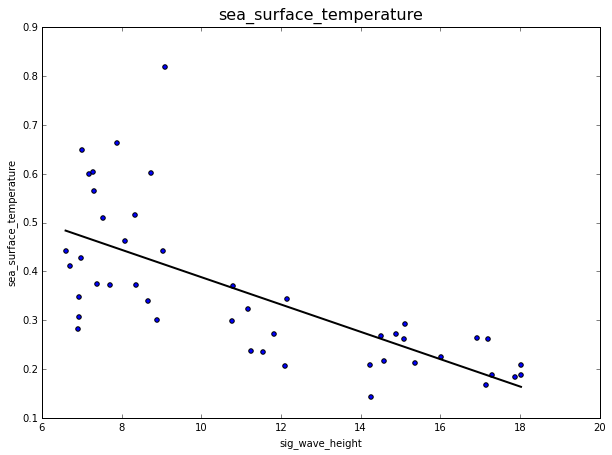

In [198]:
# Executing linear regression model for munged sea surface temperature and significant wave height data
linear_regression(background.sea_surface_temperature, background.sig_wave_height)

In [750]:
def linear_model(x_variable, y_variable):
    '''Function creates linear model and produces 
    a statistical summary'''
    
     # assigning function variables to response and predictor variables
    y = y_variable # response
    X = x_variable # predictor
    X = sm.add_constant(X)  # Adds a constant term to the predictor (essential to obtain the constant in the formula)
    
    # Producing the linear model
    lm = sm.formula.OLS(y, X).fit()
    
    # returning the linear model's summary
    return lm.params

In [751]:
# Executing the linear model function for munged sea surface temperature and significant wave height data
wave_temp = linear_model(background.sea_surface_temperature, background.sig_wave_height)
wave_temp

const                      0.668350
sea_surface_temperature   -0.028008
dtype: float64

In [675]:
def extract_pvalues(linear_model):
    '''Function creates a table of p-values for a specified 
    linear model. Only required inputs are the year of linear 
    model data and linear model name'''
    
    # Inputting the linear model p-values into a dataframe
    # Contextual information added into dataframe
    # Dataframe assigned to a variable
    lmp_1 = pd.DataFrame({'value': linear_model.pvalues, 'test': 'linear regression', 'timeframe': '2009-2012', 'stat': 'p-value'})
    
    # Changing the index column to years
    # Creating a new column for index inputs (doubling the index column)
    lmp_1.insert(3, 'variable',lmp_1.index)
    # changing the index to year (doubling the year column)
    lmp_1.index = lmp_1.stat
    # Deleting the extra year column
    del lmp_1['stat']
    
    # returning the p-value table
    return lmp_1

In [676]:
# Creating a p-value table for significant wave height and sea surface temperature relationship
p_wave_temp = extract_pvalues(wave_temp)

In [686]:
def extract_rvalues(linear_model):
    '''Function creates a table of r-squared values for a specified 
    linear model. Only required input is the linear 
    model  name'''
    
    # Inputting the linear model r-squared values into a dataframe
    # Contextual information added into dataframe
    # Dataframe assigned to a variable
    lmp_2 = pd.DataFrame({ 'value' : [linear_model.rsquared], 'test': ['linear regression'], 'timeframe' : '2009-2012', 'stat': 'r-squared'})
    
    # Changing the index column to years
    # Creating a new column for index inputs (doubling the index column)
    lmp_2.insert(3, 'variable',lmp_2.index)
    # changing the index to stat (doubling the year column)
    lmp_2.index = lmp_2.stat
    # Deleting the extra year column
    del lmp_2['stat']
    
    # returing the r-squared table
    return lmp_2

In [687]:
# creating an r-value table for significant wave height and sea surface temperature relationship
r_wave_temp = extract_rvalues(wave_temp)


In [688]:
def master_table(p_value_table, r_value_table, savename):
    '''Function combines r-squared and p-value tables toegther into a master table.
    Function requires 1 r-squared table, 1 p-value table (must have the same column titles),
    and a savename (must be in quotations) as input'''
    
    # appending the tables together to create a master table
    r_a = p_value_table.append(r_value_table)
    
    # saving file to results
    r_a.to_csv('../results/computational_experiments/'+savename+'.csv')

In [685]:
# Combining the r-squared table and the p-value table together and saving into results
master_table(p_wave_temp, r_wave_temp, 'wave_temp_stats')

The series of functions above is great for producing linear models and linear regression lines between two varaibles, however I have three variables of interest; sea surface temperature, significant wave height, and zooplankton abundance. Therefore I need to multivariate liner regression to explore the statistical relationship between my three variables. The code for this multivaraite linear regression is below, however I have yet to develop a general formula for this multivaraite linear regression. In the cells below I have individually produced 4 different statistical summaries(one for each year between 2009 and 2012) for the multivariate interactions between sea surface temperature significant wave height and zooplankton abundance. These plots were created from the results of my spring week function which are composed of weekly averaged data for the spring bloom season. Moving forward I woould like to find a general code that would produce these summaries and plot the linear regression for any 3 varaibles. 

In [689]:
def linear_model_multi(x1_variable, x2_variable, y_variable):
    '''Function creates multivaraite linear model and produces 
    a statistical summary'''
    
    Y = y_variable
    X = pd.DataFrame({'x1':x1_variable, 'x2':x2_variable})
    X = sm.add_constant(X)

    lm = sm.OLS(Y, X).fit()
    return lm.summary()

In [754]:
def linear_model_multi_interaction(x1_variable, x2_variable, y_variable):
    '''Function creates multivaraite interaction linear model and produces 
    a statistical summary'''
    
    assert len(x1_variable) > 1, 'The length of x variable 1 should be larger than 1'
    assert len(x2_variable) > 1, 'The length of x variable 2 should be larger than 1'
    assert len(y_variable) > 1, 'The length of the y variable should be larger than 1'
    
    # Assigning a variable to y_variable input
    Y = y_variable
    # Creating a dataframe to hold both x variables and their interaction term
    X = pd.DataFrame({x1_variable.name :x1_variable, x2_variable.name :x2_variable, x2_variable.name+' '+'&'+' '+ x1_variable.name:(x1_variable*x2_variable)})
    # Adding a constant to the dataframe (essential to obtain the constant in the linear model)
    X = sm.add_constant(X)
    
    # Producing a multivariate linear model with an interaction term
    lm = sm.OLS(Y, X).fit()
    
    # Returning this linear model
    return lm

In [755]:
# Making a multivariate linear model for significant wave height, sea surface temperature, and Zooplankton Abundance for each spring bloom season
lm_2012 = linear_model_multi_interaction(comb_2012.sea_surface_temperature, comb_2012.sig_wave_height, comb_2012.Total_Zooplankton_Abundance)
lm_2011 = linear_model_multi_interaction(comb_2011.sea_surface_temperature, comb_2011.sig_wave_height, comb_2011.Total_Zooplankton_Abundance)
lm_2010 = linear_model_multi_interaction(comb_2010.sea_surface_temperature, comb_2010.sig_wave_height, comb_2010.Total_Zooplankton_Abundance)
lm_2009 = linear_model_multi_interaction(comb_2009.sea_surface_temperature, comb_2009.sig_wave_height, comb_2009.Total_Zooplankton_Abundance)

In [758]:
lm_2012.params

const                                         5368.811650
sea_surface_temperature                       -318.687809
sig_wave_height                             -11318.700775
sig_wave_height & sea_surface_temperature      882.650839
dtype: float64

In [759]:
lm_2011.params

const                                        5090.907596
sea_surface_temperature                      -198.535166
sig_wave_height                             -4526.358919
sig_wave_height & sea_surface_temperature     -81.419729
dtype: float64

In [760]:
lm_2010.params

const                                        1859.607571
sea_surface_temperature                        61.078771
sig_wave_height                             -3740.053091
sig_wave_height & sea_surface_temperature     186.186017
dtype: float64

In [761]:
lm_2009.params

const                                       -1179.772544
sea_surface_temperature                       250.976622
sig_wave_height                              2000.797642
sig_wave_height & sea_surface_temperature    -326.433527
dtype: float64

In [561]:
def pvalue_table(year, linear_model):
    '''Function creates a table of p-values for a specified 
    linear model. Only required inputs are the year linear 
    model data and linear model name'''
    
    assert 2009 <= year <=2012, 'The year should be between 2009 and 2012'
    
    # Inputting the linear model p-values into a dataframe
    # Contextual information added into dataframe
    # Dataframe assigned to a variable
    lmp_1 = pd.DataFrame({'value': linear_model.pvalues, 'test': 'linear regression', 'year': year})
    
    # Changing the index column to years
    # Creating a new column for index inputs (doubling the index column)
    lmp_1.insert(3, 'variable',lmp_1.index)
    # changing the index to year (doubling the year column)
    lmp_1.index = lmp_1.year
    # Deleting the extra year column
    del lmp_1['year']
    
    # returning the p-value table
    return lmp_1

In [562]:
# Making a table to hold the p-value from each spring's multivariate linear model
p_2012 = pvalue_table(2012, lm_2012)
p_2011 = pvalue_table(2011, lm_2011)
p_2010 = pvalue_table(2010, lm_2010)
p_2009 = pvalue_table(2009, lm_2009)

In [602]:
def master_ptable(p_1, p_2, p_3, p_4, savename):
    '''Function combines four p-value tables toegther into a master table.
    Function requires 4 p-value tables (must have the same column titles),
    and a savename in quotations as input'''
    
    assert type(savename) == str, 'the savename must be in a string format'
    
    # appending the tables together to create a master table
    p_a = p_1.append(p_2)
    p_b = p_a.append(p_3)
    p_c = p_b.append(p_4)
    
    # saving the table under the specified savename into project results
    p_c.to_csv('../results/'+savename+'.csv')
    

In [603]:
# Combines all the tables together for easy comparison and saves master table to the results folder
master_ptable(p_2012, p_2011, p_2010, p_2009, 'p_values')

In [601]:
def rsquared_table(year, linear_model):
    '''Function creates a table of r-squared values for a specified 
    linear model. Only required inputs are the year linear 
    model data and linear model name'''
    
    assert 2009 <= year <=2012, 'The year should be between 2009 and 2012'
    
    # Inputting the linear model r-squared values into a dataframe
    # Contextual information added into dataframe
    # Dataframe assigned to a variable
    lmp_2 = pd.DataFrame({ 'r_squared' : [linear_model.rsquared], 'test': ['linear regression'], 'year' : [year]})
    
    # Changing the index column to years
    # Creating a new column for index inputs (doubling the index column)
    lmp_2.insert(3, 'variable',lmp_2.index)
    # changing the index to year (doubling the year column)
    lmp_2.index = lmp_2.year
    # Deleting the extra year column
    del lmp_2['year']
    
    # returing the r-squared table
    return lmp_2



In [605]:
# Making a table to hold the r-squared value from each spring's multivariate linear model
r_2012 = rsquared_table(2012, lm_2012)
r_2011 = rsquared_table(2011, lm_2011)
r_2010 = rsquared_table(2010, lm_2010)
r_2009 = rsquared_table(2009, lm_2009)

In [608]:
def master_rtable(r_1, r_2, r_3, r_4, savename):
    '''Function combines four r-squared tables toegther into a master table.
    Function requires 4 r-squared tables (must have the same column titles),
    and a savename in quotations as input'''
    
    assert type(savename) == str, 'the savename must be in a string format'
    
    # appending the tables together to create a master table
    r_a = r_1.append(r_2)
    r_b = r_a.append(r_3)
    r_c = r_b.append(r_4)
    
    r_c.to_csv('../results/'+savename+'.csv')
    

In [609]:
# Combines all the tables together for easy comparison and saves master table to the results folder
master_rtable(r_2012, r_2011, r_2010, r_2009, 'rsqured')